In [1]:
import os
import shutil
import re
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from pandas.plotting import table 
from matplotlib.table import table
pd.set_option('display.max_rows', 500)


In [2]:
#Function to find the MR files for flow B

def finding_MR(filename):
        match0000 = re.match(r'flow_100_retro_B_MR(\d+)_P_(\d+)__ph.nii', filename)
        match0001 = re.match(r'([A-Z]+_(\d+)[A-Z].nii.gz)', filename)
        
        if match0000:
            mr_number=match0000.group(1).zfill(2)
        elif match0001:
            mr_number=match0001.group(2).zfill(2)
        else:
            #print('No match')
            mr_number= False
            return mr_number
        return mr_number

In [ ]:
#Function to find the MR files for flow A

def finding_MR(filename):
        match0000 = re.match(r'flow_(?:200|150)_retro_A_MR(\d+)_P_(\d+)__ph.nii', filename)
        match0001 = re.match(r'([A-Z]+_(\d+)[A-Z].nii.gz)', filename)
        
        if match0000:
            mr_number=match0000.group(1).zfill(2)
        elif match0001:
            mr_number=match0001.group(2).zfill(2)
        else:
            #print('No match')
            mr_number= False
            return mr_number
        return mr_number

In [3]:
#Function to find the patient initials files

def extract_pt_and_day(path_folder):
    # Extract the last segment of the folder path
    base_name = os.path.basename(path_folder)
    
    # Using regex to find initials and day
    # This assumes 'FP_' followed by exactly two letters and '/Dag' followed by exactly one letter from A-H
    pt_match = re.search(r'FP_([A-Z]{2})', path_folder)
    day_match = re.search(r'Dag([A-H])', path_folder)
    
    if not pt_match or not day_match:
        raise ValueError("Could not find proper pt or day in the path.")
    
    pt = pt_match.group(1)
    day = day_match.group(1)
    
    return pt, day

In [4]:
# Function to squeeze data
def img_data(path_img):
    img=nib.load(path_img)
    data_img=img.get_fdata()
    data_img_squezed=np.squeeze(data_img)
    #img_data=np.transpose(data_img_squezed, (1, 0, 2))
    return data_img_squezed

In [5]:
# Function to find labels

def lbl_data(path_lbl):
    lbl=nib.load(path_lbl)
    data_lbl=np.flipud(lbl.get_fdata())
    #print(data_lbl.shape)
    return data_lbl

In [14]:
def flow_calc(data_img, data_lbl, vox_x, vox_y, venc, frames):
    # Assuming data_img is a 3D numpy array and data_lbl contains the masks
    mask_mes = data_lbl == 1  # Example condition for creating mask_mes
    mask_truncus = data_lbl == 2  # Example condition for creating mask_truncus
    
    flow_mes_array = []
    flow_trunc_array = []

    for i in range(data_img.shape[2]):
        phase_skive = data_img[:, :, i]

        # Extract the corresponding slice from the mask and transpose it
        mask_mes_slice = mask_mes[:, :, i].T  # Transpose to match the shape of phase_skive
        mask_truncus_slice = mask_truncus[:, :, i].T  # Transpose to match the shape of phase_skive

        # Ensure the mask slice has the same shape as the image slice
        if mask_mes_slice.shape != phase_skive.shape:
            raise ValueError(f"Shape mismatch: mask_mes_slice shape {mask_mes_slice.shape} and phase_skive shape {phase_skive.shape} do not match.")
        if mask_truncus_slice.shape != phase_skive.shape:
            raise ValueError(f"Shape mismatch: mask_truncus_slice shape {mask_truncus_slice.shape} and phase_skive shape {phase_skive.shape} do not match.")

        # Apply the mask slice to the image data to extract values
        masked_image_p_values_mes = phase_skive[mask_mes_slice]
        masked_image_p_values_truncus = phase_skive[mask_truncus_slice]

        # Perform calculations with masked_image_p_values_mes and masked_image_p_values_truncus
        # Example calculation (you'll need to replace this with your actual calculations)
        flow_mes = np.sum(masked_image_p_values_mes) * vox_x * vox_y
        flow_truncus = np.sum(masked_image_p_values_truncus) * vox_x * vox_y

        flow_mes_array.append(flow_mes)
        flow_trunc_array.append(flow_truncus)

    # Return the calculated flow values
    return np.sum(flow_mes_array), np.sum(flow_trunc_array), flow_mes_array, flow_trunc_array

# Usage of the function remains the same
data_img = img_data(path_img)  # Define this function to load image data
data_lbl = lbl_data(path_lbl)  # Define this function to load label data
vox = nib.load(path_img).header.get_zooms()  # Get voxel dimensions
flow_mes, flow_truncus, flow_mes_array, flow_trunc_array = flow_calc(data_img, data_lbl, vox[0], vox[1], venc, frames)


In [6]:
#Function to calculate the flow
def flow_calc (image_data, label_data, vox_x, vox_y, venc, frames):

    frames = label_data.shape[2] 

    # Creating a mask from the label
    flow_mes_array=np.zeros(frames)
    flow_trunc_array=np.zeros(frames)

    # area_mes=np.zeros(25)
    # area_truncus=np.zeros(25)

    for i in range (frames):
        mask_mes = label_data[:,:,i] == 1
        mask_truncus = label_data[:,:,i] ==2
        phase_skive = image_data[:,:,i]

        # Apply the mask to the image data to extract values
        masked_image_p_values_mes = phase_skive[mask_mes]
        masked_image_p_values_truncus = phase_skive[mask_truncus]

        #calculating the area of the ROI
        area_mes = ((np.sum(mask_mes)*vox_x*vox_y))
        area_truncus = ((np.sum(mask_truncus)*vox_x*vox_y))

        #calculating the mean velocity within the mask
        vel_mes=(np.mean(masked_image_p_values_mes)/4096)*venc
        vel_trunc= (np.mean(masked_image_p_values_truncus)/4096)*venc

        #calculating flow and changing the area from mm² --> cm² and velocity from cm/s--> cm/min
        flow_mes_array[i]=(area_mes*0.01)*(vel_mes*60) if area_mes > 0 else 0
        flow_trunc_array[i] = (area_truncus*0.01)*(vel_trunc*60) if area_truncus > 0 else 0

    # getting the mean flow and getting the absolute value
    flow_mes = np.abs(np.mean(flow_mes_array))
    flow_truncus = np.abs(np.mean(flow_trunc_array))

    #print(f'The flow for mes is {flow_mes:.3f} ml/min')
    #print(f'The flow for truncus is {flow_truncus:.3f} ml/min')
    return flow_mes, flow_truncus, flow_mes_array, flow_trunc_array
    

In [7]:
def baseline_divided_flow(results_df):
    mr_data = {}
    baseline_divided_flow_mes_results = {}
    baseline_divided_flow_truncus_results = {}
    # Loop through numbers 1 to 12 and create DataFrame entries in the dictionary
    for i in range(1, 13):
        mr_number = f'{i:02}'  # Formats number as two digits, e.g., 01, 02, ... 12
        mr_data[mr_number] = results_df[results_df['MR_Number'] == mr_number]

In [8]:
def baseline_divided_flow(results_df):
    mr_data = {}
    baseline_divided_flow_mes_results = {}
    baseline_divided_flow_truncus_results = {}
    # Initialize variables to prevent UnboundLocalError
    baseline_flow_mes = 0
    baseline_flow_truncus = 0
    has_baseline = False

    # Loop through numbers 1 to 12 and create DataFrame entries in the dictionary
    for i in range(1, 12):
        mr_number = f'{i:02}'  # Formats number as two digits, e.g., 01, 02, ... 12
        mr_data[mr_number] = results_df[results_df['MR_Number'] == mr_number]

    # Calculating baseline if both MR1 and MR2 are present and contain data
    if not mr_data['01'].empty and not mr_data['02'].empty:
        baseline_flow_mes = (mr_data['01']['Flow_Mes'].iloc[0] + mr_data['02']['Flow_Mes'].iloc[0]) / 2
        baseline_flow_truncus = (mr_data['01']['Flow_Truncus'].iloc[0] + mr_data['02']['Flow_Truncus'].iloc[0]) / 2
        has_baseline = True
        print(f"The baseline mes flow for MR1 and MR2 is {baseline_flow_mes:.3f} ml/min")
        print(f"The baseline truncus flow for MR1 and MR2 is {baseline_flow_truncus:.3f} ml/min")
    else:
        print("MR1 or MR2 data not found. Cannot calculate baseline.")

    # Only proceed with calculations if baseline data was found
    if has_baseline:
        for i in range(3, 13):
            mr_number = f'{i:02}'
            if mr_number in mr_data and not mr_data[mr_number].empty:
                # Check if the required data is present
                if len(mr_data[mr_number]['Flow_Mes']) > 0 and len(mr_data[mr_number]['Flow_Truncus']) > 0:
                    baseline_divided_flow_mes_results[mr_number] = baseline_flow_mes / mr_data[mr_number]['Flow_Mes'].iloc[0] * 100
                    baseline_divided_flow_truncus_results[mr_number] = baseline_flow_truncus / mr_data[mr_number]['Flow_Truncus'].iloc[0] * 100
        print(f'Subject: {pt}, Day: {day}')
        print("Baseline Divided Flow Mes Results:")
        for mr, value in baseline_divided_flow_mes_results.items():
            print(f"MR{mr}: {value:.3f}")

        print("Baseline Divided Flow Truncus Results:")
        for mr, value in baseline_divided_flow_truncus_results.items():
            print(f" MR{mr}: {value:.3f}")

    return baseline_divided_flow_mes_results, baseline_divided_flow_truncus_results


In [9]:
def dictionaries_to_dataframe(SMA, TC, days):
    # Create a list for DataFrame creation
    data = []
    for day in days:
        for mr_number in SMA.get(day, {}):  # Ensure day exists in SMA and TC dictionaries
            sma_value = SMA[day].get(mr_number, None)
            tc_value = TC[day].get(mr_number, None)
            data.append({'Day': day, 'MR_Number': mr_number, 'SMA': sma_value, 'TC': tc_value})
    
    # Create DataFrame
    return pd.DataFrame(data, columns=['Day', 'MR_Number', 'SMA', 'TC'])


In [10]:
def plot_baseline_divided_flow(flow_df):
    # Set the color map to use. We use a colormap to generate distinct colors for each day.
    colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
    
    # Create a new figure and set its size
    plt.figure(figsize=(10, 6))
    
    # Iterate through each unique day in the DataFrame
    for index, day in enumerate(sorted(flow_df['Day'].unique())):
        # Filter the DataFrame by day
        day_data = flow_df[flow_df['Day'] == day]
        
        # Plot 'SMA' for this day
        plt.plot(day_data['MR_Number'], day_data['SMA'], label=f'Day {day} - SMA', color=colormap(index))
        
        # Plot 'TC' for this day in a different style
        plt.plot(day_data['MR_Number'], day_data['TC'], label=f'Day {day} - TC', linestyle='--', color=colormap(index))
    
    # Add title and labels
    plt.title('Baseline Divided Flow Measurements by Day')
    plt.xlabel('MR Number')
    plt.ylabel('Baseline Divided Flow (%)')
    
    # Add a legend to the plot
    plt.legend()
    
    # Show the plot
    plt.show()


/tmp/ipykernel_117924/1258038046.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)
/tmp/ipykernel_117924/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is -26989.889 ml/min
The baseline truncus flow for MR1 and MR2 is 36234.376 ml/min
Subject: HL, Day: H
Baseline Divided Flow Mes Results:
MR03: 12.591
MR04: 4.190
MR05: 0.731
MR06: 8.461
MR07: 12.083
MR08: -76.056
MR09: 32.006
MR10: 911.437
MR11: 5.298
Baseline Divided Flow Truncus Results:
 MR03: 135.372
 MR04: 28.558
 MR05: -11.433
 MR06: 13.905
 MR07: 30.133
 MR08: 34.423
 MR09: 37.263
 MR10: 61.104
 MR11: -65.386


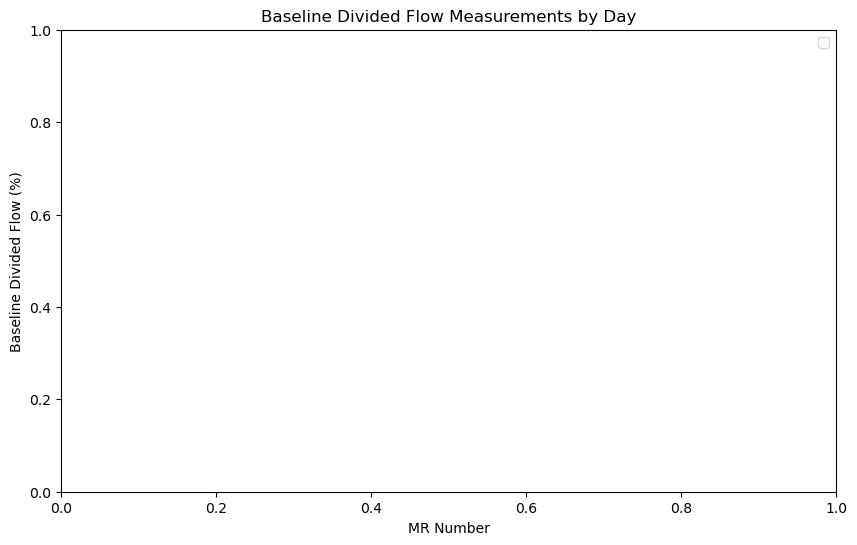

Data written to HL_true_VH.txt


In [15]:
# Set the path to the data
path_img_base = "/run/user/1000/gvfs/smb-share:server=10.141.40.29,share=loggededata/GA17/MRdata/FP_"
path_lbl_base = '/home/klinfys/Desktop/nnUNet_raw/Dataset502_VenaHepa3D/'

frames = 25
venc = 100
Type = 'Ts'
days = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
initials = 'HL'

# Creating an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Patient', 'Day', 'MR_Number', 'Flow_Mes', 'Flow_Truncus'])

for day in days:
    path_folder = f"/run/user/1000/gvfs/smb-share:server=10.141.40.29,share=loggededata/GA17/MRdata/FP_{initials}/Dag{day}"
    for filename in os.listdir(path_folder):
        if "ph" in filename and filename.endswith('.nii'):
            Mr_number = finding_MR(filename)
            if Mr_number is False:
                continue
            path_img = os.path.join(path_folder, filename)
            pt, day_extracted = extract_pt_and_day(path_folder)
            #path_lbl = f'{path_lbl_base}/labels{Type}/{pt}_{Mr_number}{day_extracted}.nii.gz' #bruges ved udregnede labels
            #path_lbl = f'{path_lbl_base}imagesTs_pred_3d_fullres/{pt}_{Mr_number}{day_extracted}.nii.gz' #bruges ved predicted labels for MT
            path_lbl = f'{path_lbl_base}imagesTs_pred_3d_fullres_final/{pt}_{Mr_number}{day_extracted}.nii.gz' #bruges ved predicted labels for VH
        
            if os.path.exists(path_lbl) and os.path.exists(path_img):
                data_img = img_data(path_img)
                data_lbl = lbl_data(path_lbl)
                vox = nib.load(path_img).header.get_zooms()
                flow_mes, flow_truncus, flow_mes_array, flow_trunc_array = flow_calc(data_img, data_lbl, vox[0], vox[1], venc, frames)
                temp_df = pd.DataFrame({
                    'Patient': [pt], 
                    'Day': [day_extracted], 
                    'MR_Number': [Mr_number], 
                    'Flow_Mes': [flow_mes], 
                    'Flow_Truncus': [flow_truncus]
                })
                results_df = pd.concat([results_df, temp_df], ignore_index=True)

# After accumulating all data
SMA, TC = baseline_divided_flow(results_df)
flow_df = dictionaries_to_dataframe(SMA, TC, days)
plot_baseline_divided_flow(flow_df)

# Define the output file path
output_file = f'{pt}_true_VH.txt'

# Write the dataframe to a .txt file in TSV format
results_df.to_csv(output_file, sep='\t', index=False)

print(f"Data written to {output_file}")



/tmp/ipykernel_117566/4199779447.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)
/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MR1 or MR2 data not found. Cannot calculate baseline.


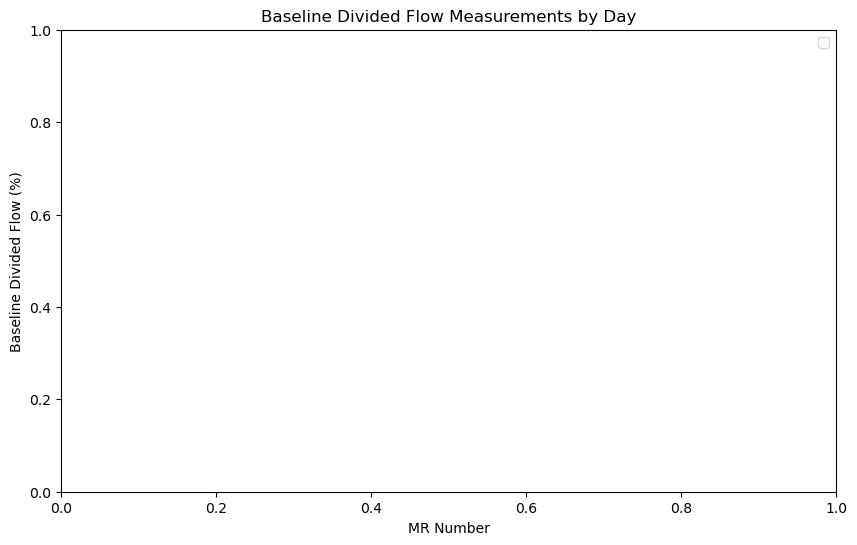

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MR1 or MR2 data not found. Cannot calculate baseline.


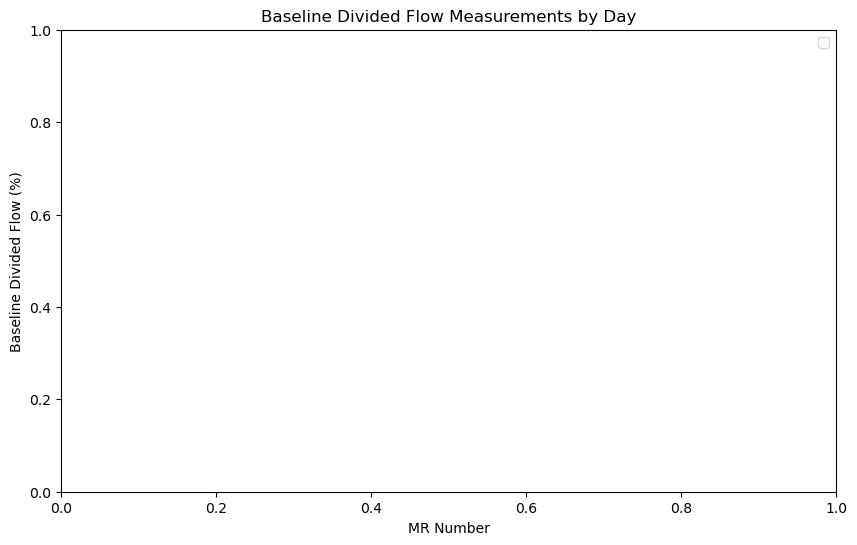

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MR1 or MR2 data not found. Cannot calculate baseline.


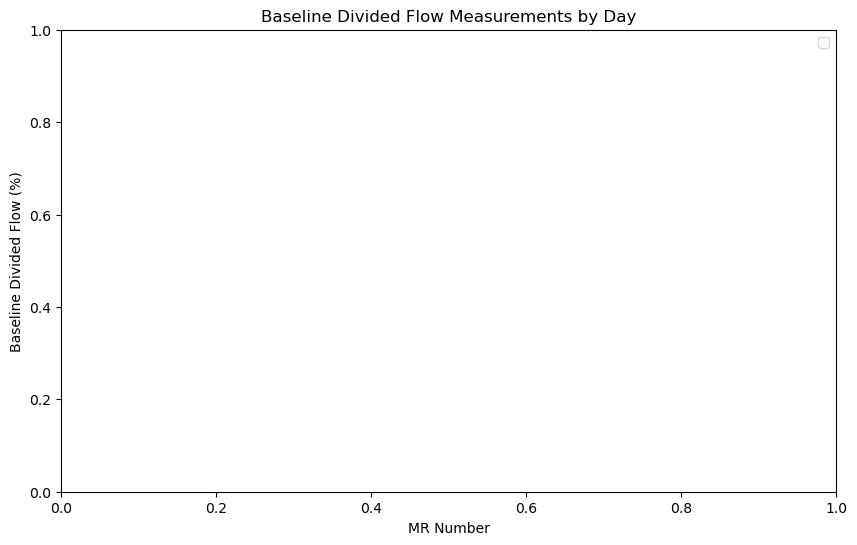

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MR1 or MR2 data not found. Cannot calculate baseline.


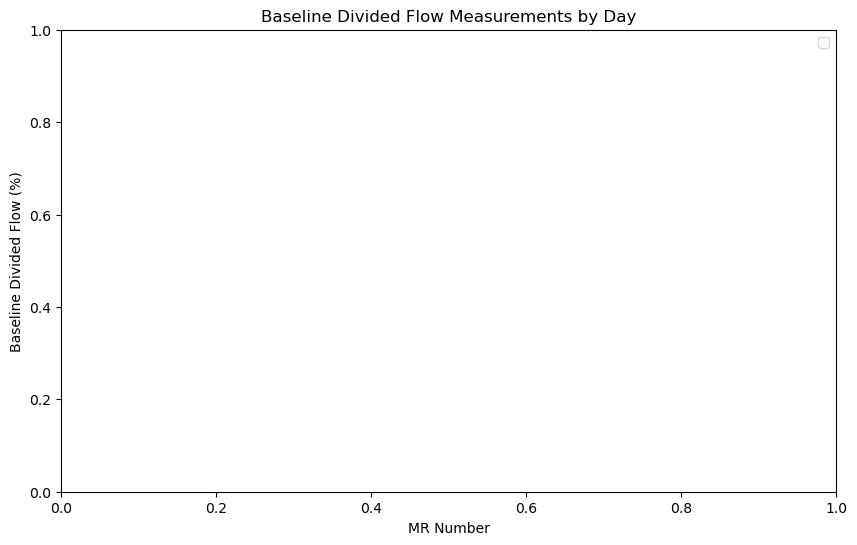

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MR1 or MR2 data not found. Cannot calculate baseline.


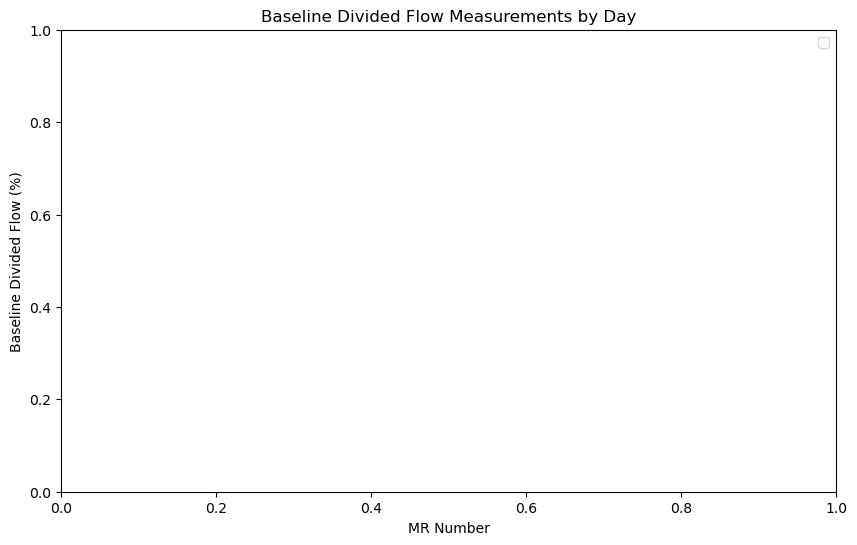

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MR1 or MR2 data not found. Cannot calculate baseline.


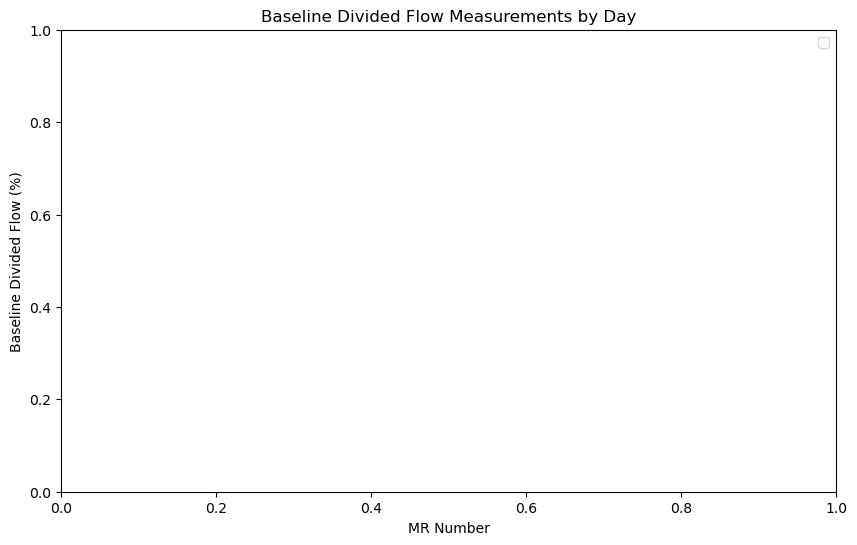

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MR1 or MR2 data not found. Cannot calculate baseline.


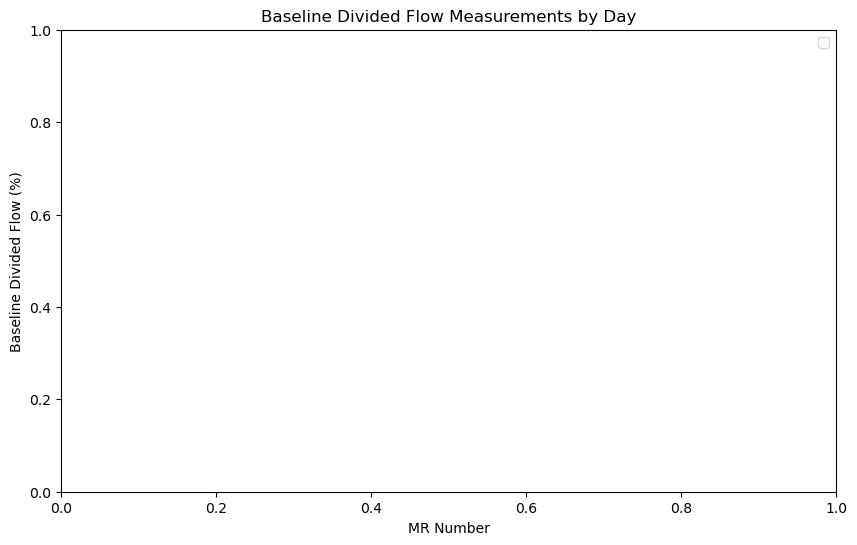

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MR1 or MR2 data not found. Cannot calculate baseline.


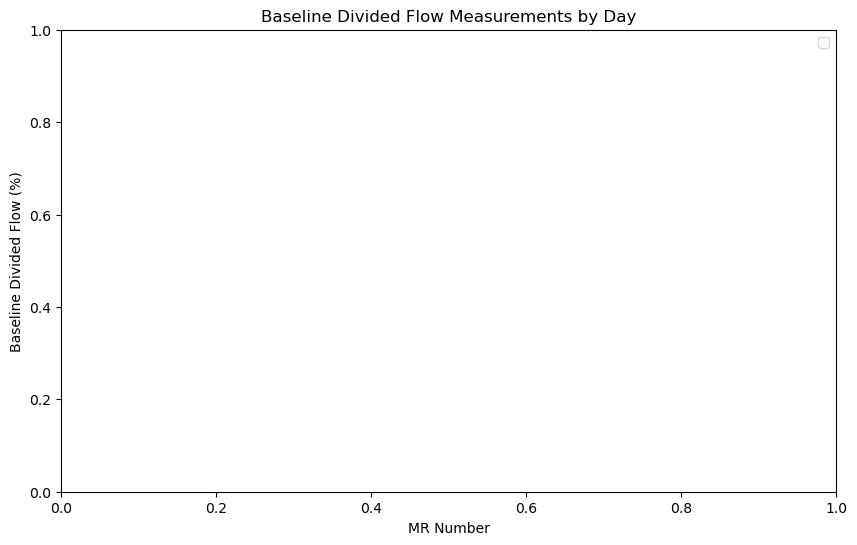

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MR1 or MR2 data not found. Cannot calculate baseline.


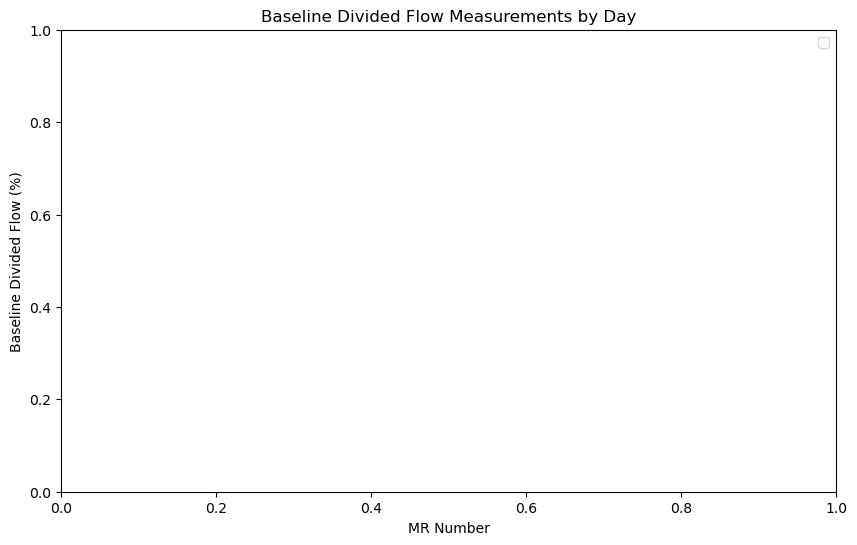

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MR1 or MR2 data not found. Cannot calculate baseline.


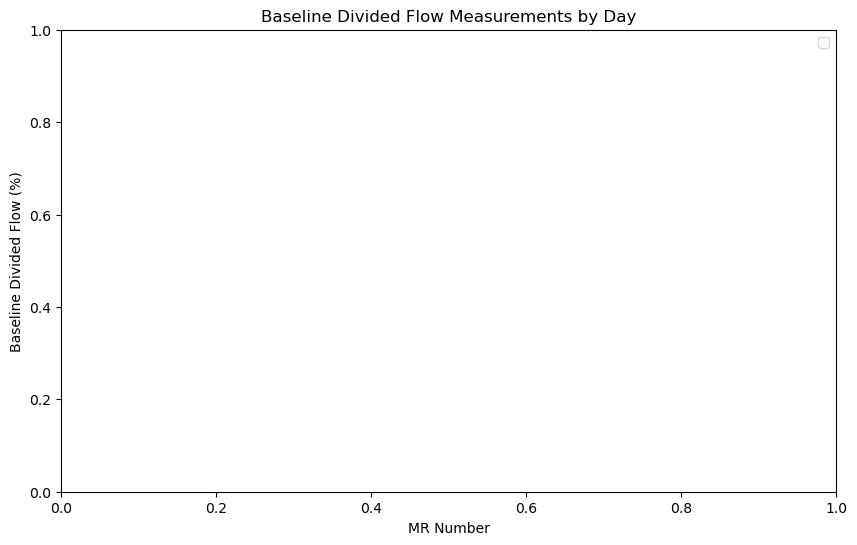

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MR1 or MR2 data not found. Cannot calculate baseline.


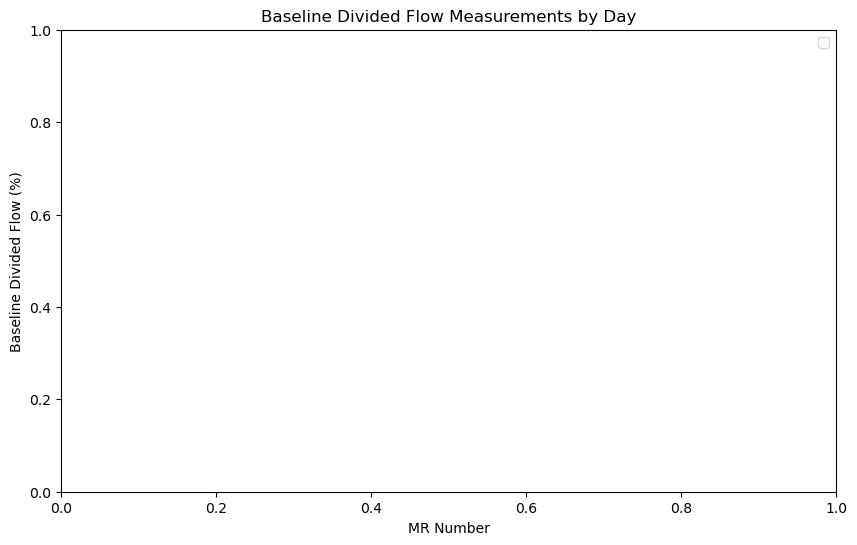

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: A
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


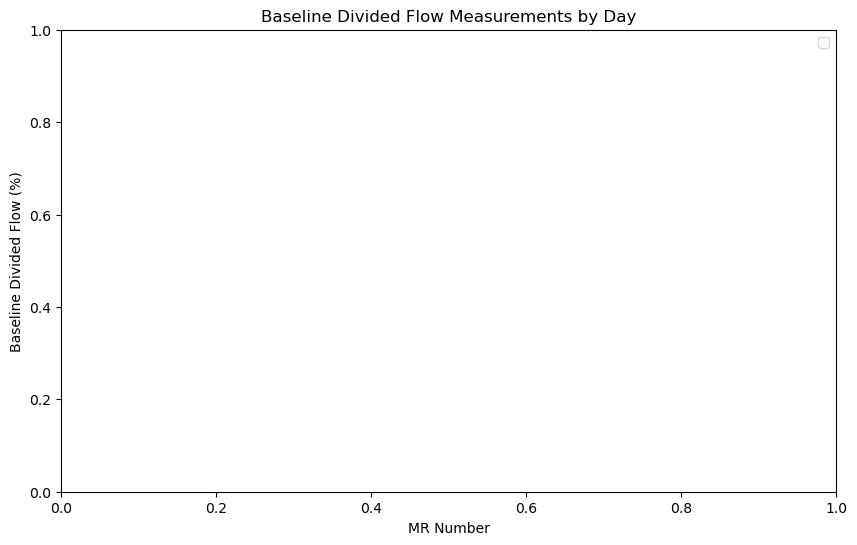

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: A
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


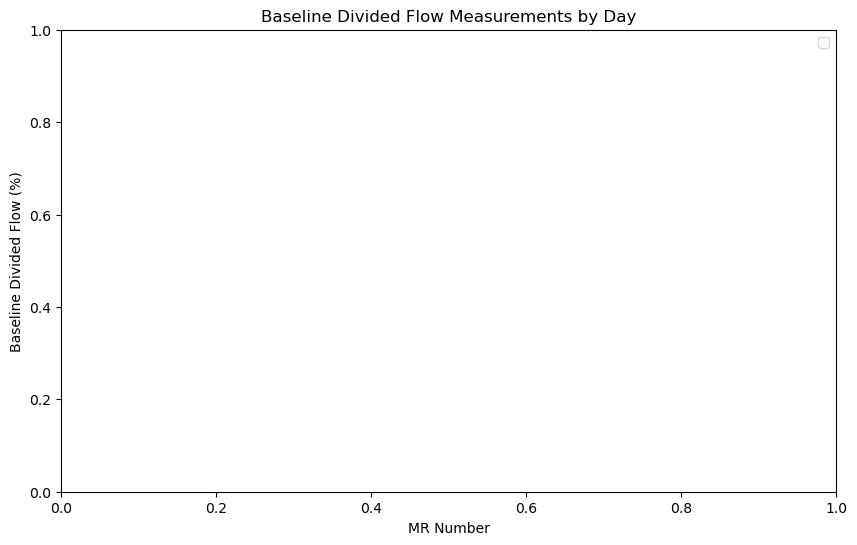

   Patient Day MR_Number    Flow_Mes  Flow_Truncus
0       WJ   A        05  778.717136    644.861788
1       WJ   A        12  856.571680    613.515827
2       WJ   A        08  841.258538    699.905373
3       WJ   A        11  841.712453    632.501442
4       WJ   A        06  754.606757    576.013798
5       WJ   A        09  891.254971    483.256516
6       WJ   A        03  590.194506    728.993522
7       WJ   A        10  881.251216    647.756962
8       WJ   A        01  450.886307    603.924828
9       WJ   A        04  853.903464    686.565464
10      WJ   A        07  717.726803    605.768708
11      WJ   A        02  542.671084    711.750656
12      WJ   A        01  554.080092    616.078208


/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


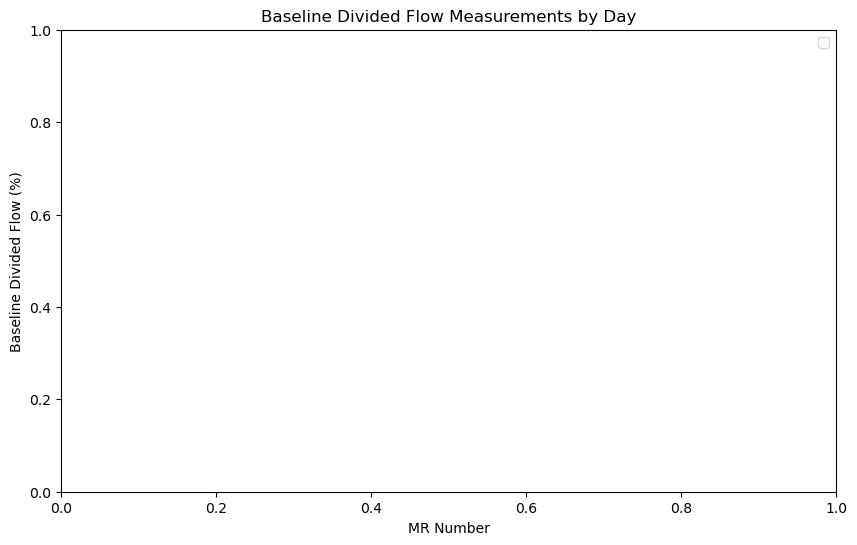

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


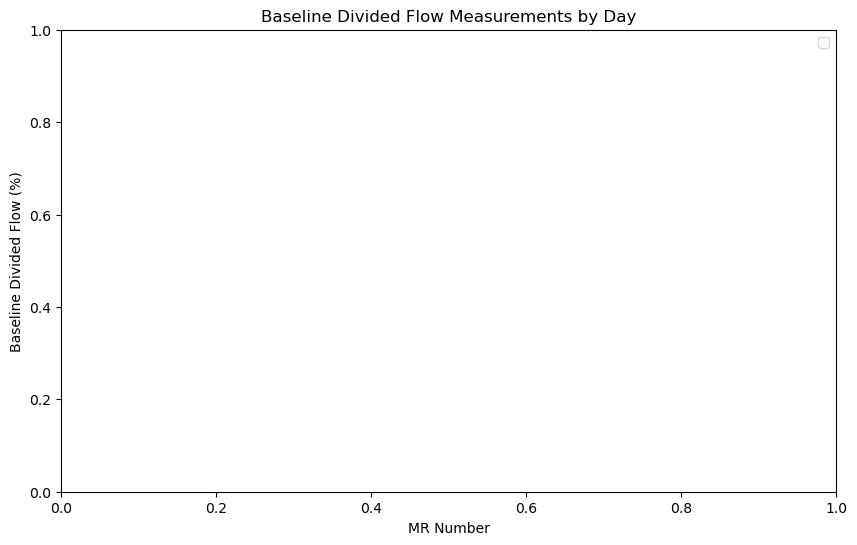

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


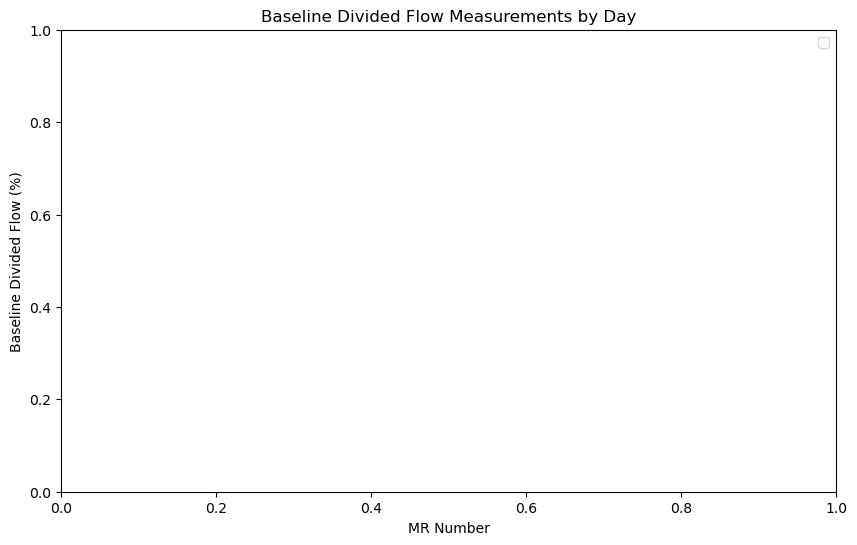

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


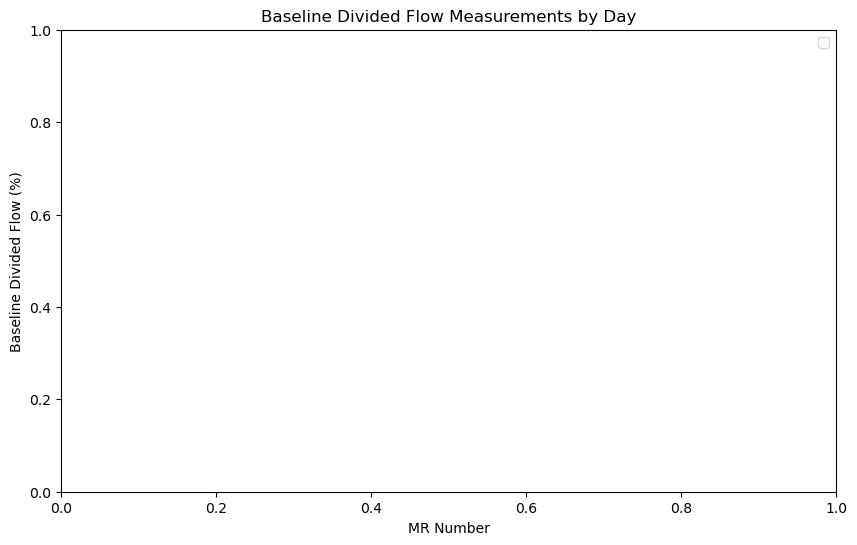

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


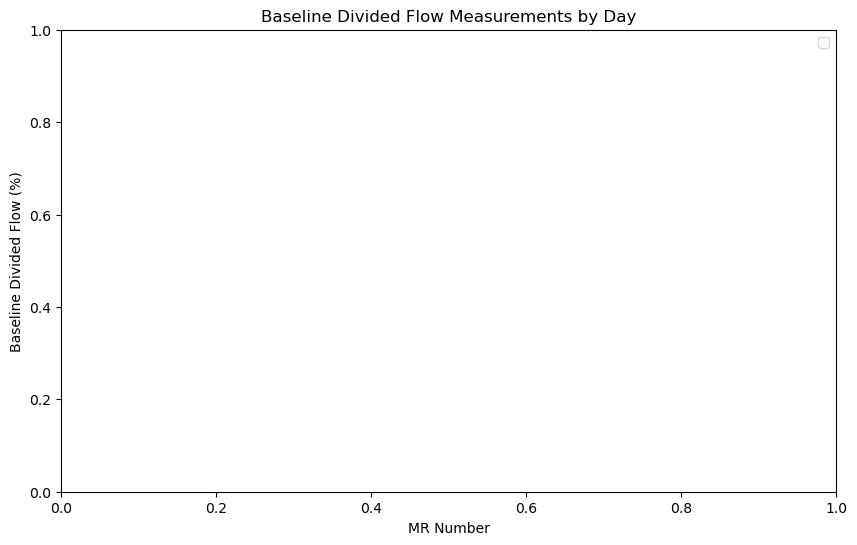

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


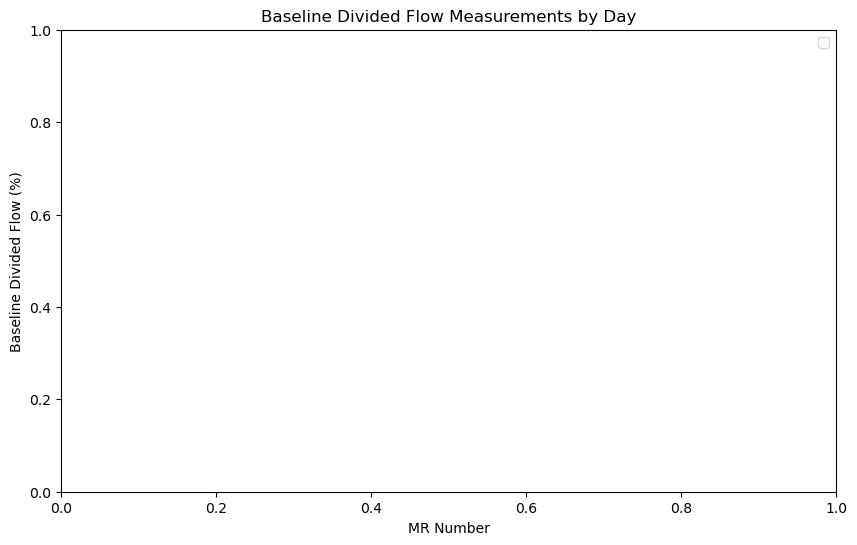

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


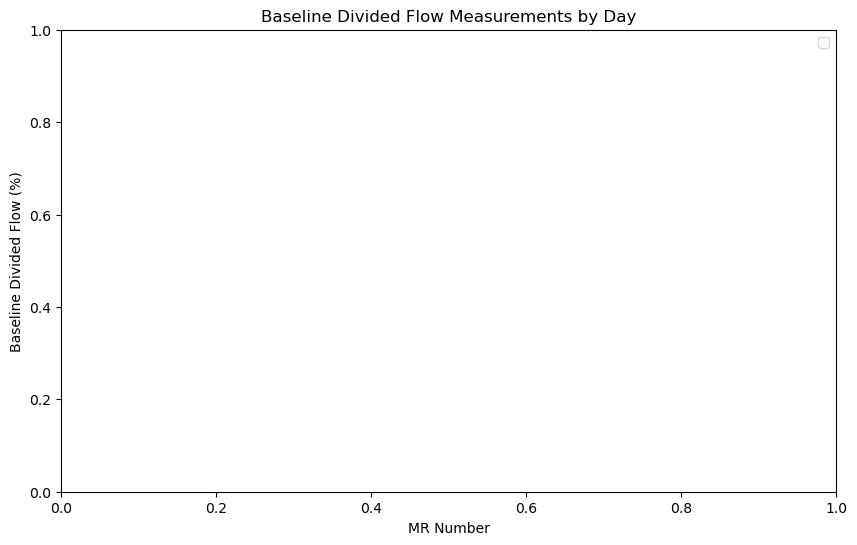

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


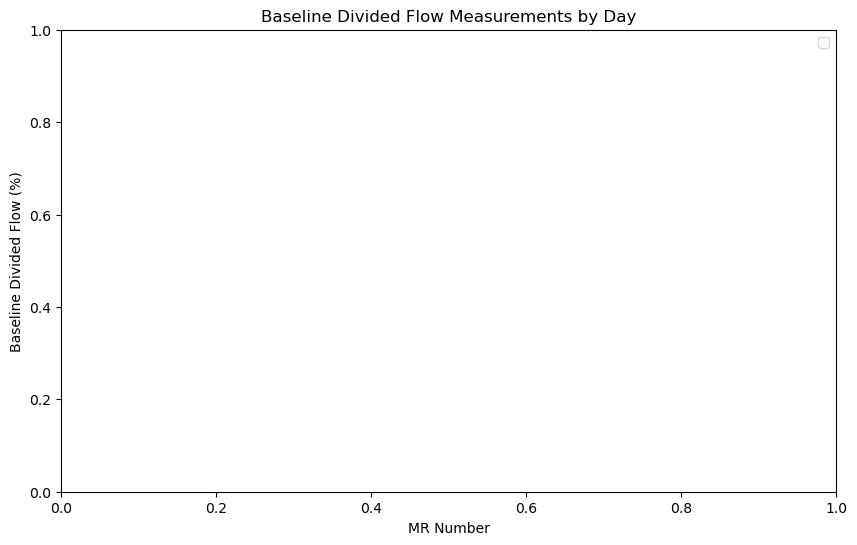

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


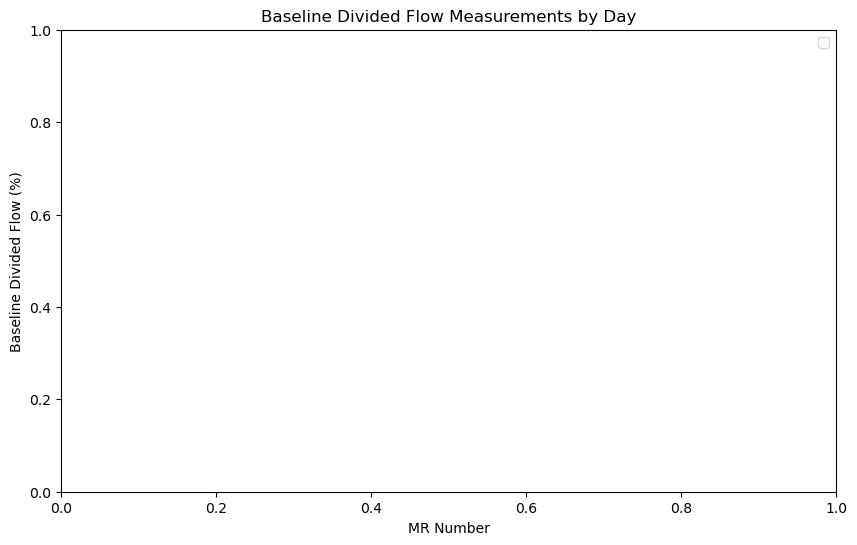

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


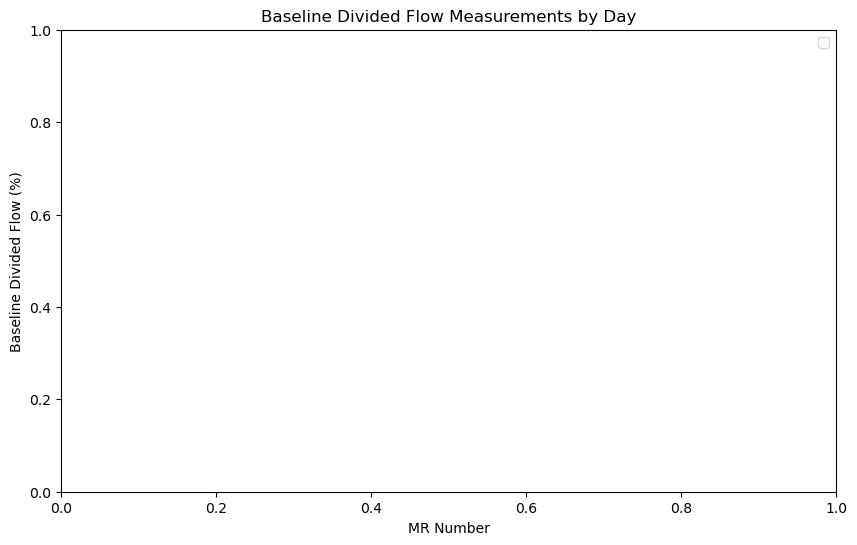

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


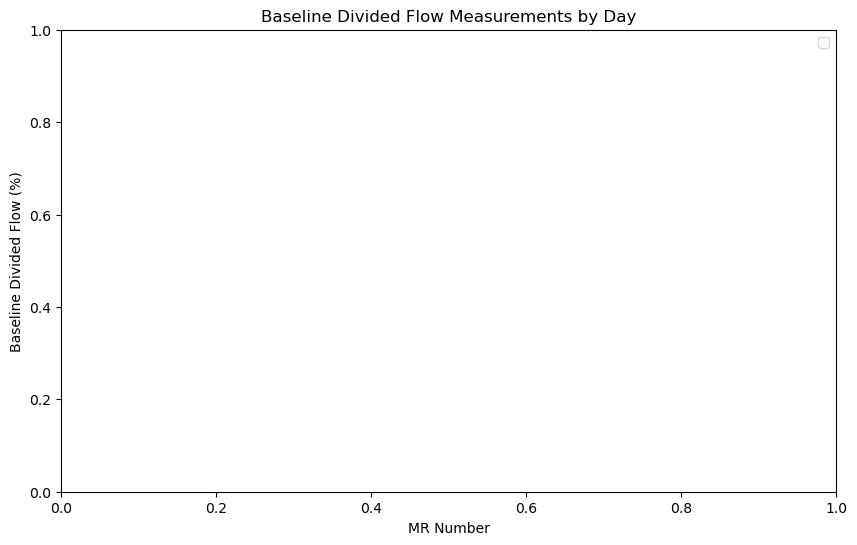

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


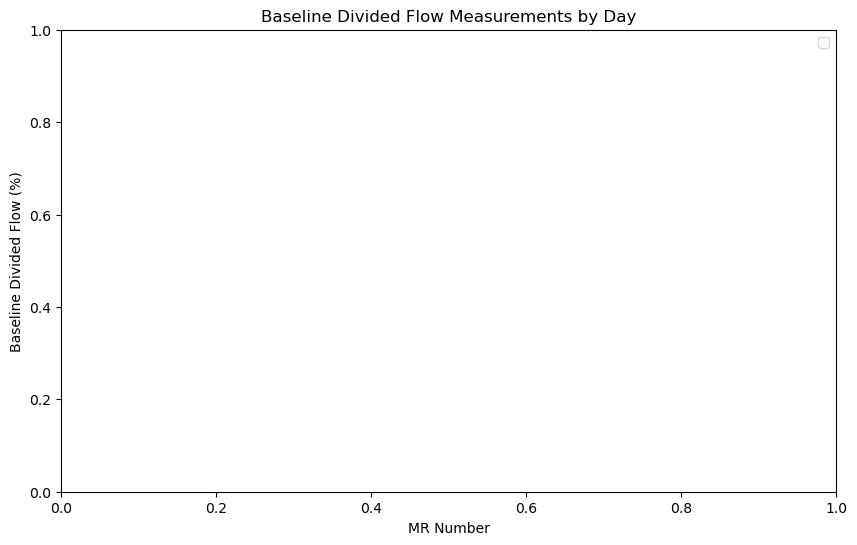

/tmp/ipykernel_117566/2981987483.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', len(flow_df['Day'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The baseline mes flow for MR1 and MR2 is 496.779 ml/min
The baseline truncus flow for MR1 and MR2 is 657.838 ml/min
Subject: WJ, Day: B
Baseline Divided Flow Mes Results:
MR03: 84.172
MR04: 58.177
MR05: 63.794
MR06: 65.833
MR07: 69.216
MR08: 59.052
MR09: 55.739
MR10: 56.372
MR11: 59.020
Baseline Divided Flow Truncus Results:
 MR03: 90.239
 MR04: 95.816
 MR05: 102.012
 MR06: 114.205
 MR07: 108.596
 MR08: 93.990
 MR09: 136.126
 MR10: 101.556
 MR11: 104.006


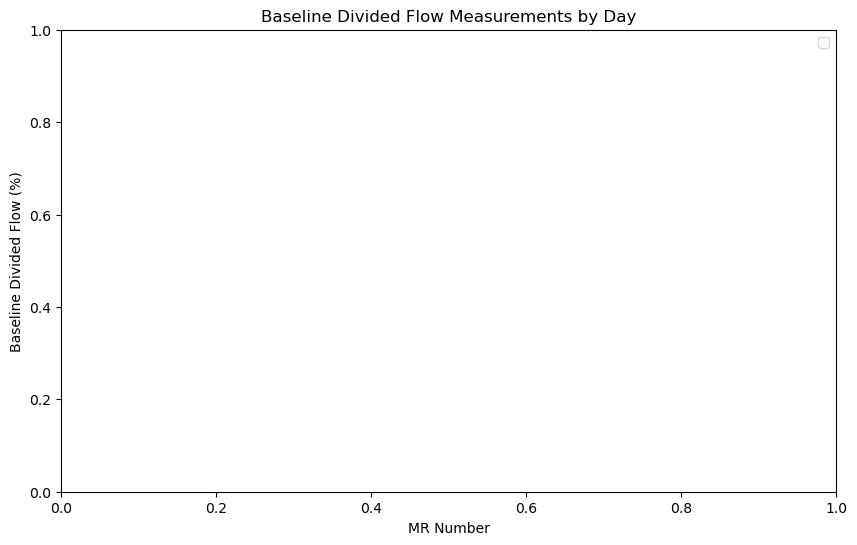

   Patient Day MR_Number    Flow_Mes  Flow_Truncus
0       WJ   A        05  778.717136    644.861788
1       WJ   A        12  856.571680    613.515827
2       WJ   A        08  841.258538    699.905373
3       WJ   A        11  841.712453    632.501442
4       WJ   A        06  754.606757    576.013798
5       WJ   A        09  891.254971    483.256516
6       WJ   A        03  590.194506    728.993522
7       WJ   A        10  881.251216    647.756962
8       WJ   A        01  450.886307    603.924828
9       WJ   A        04  853.903464    686.565464
10      WJ   A        07  717.726803    605.768708
11      WJ   A        02  542.671084    711.750656
12      WJ   A        01  554.080092    616.078208
13      WJ   B        10  708.409799    695.221588
14      WJ   B        05  701.663409    813.954296
15      WJ   B        09  593.343684    654.866719
16      WJ   B        01  557.083453    580.708166
17      WJ   B        04  583.956124    578.076404
18      WJ   B        07  624.3

In [13]:
# Set the path to the data
path_img_base = "/run/user/1000/gvfs/smb-share:server=10.141.40.29,share=loggededata/GA17/MRdata/FP_"
path_lbl_base = '/home/klinfys/Desktop/nnUNet_raw/Dataset724_MesTruncus3D/labels'



frames = 25
venc = 200
Type = 'Tr'
days = ['A', 'B']

# Creating an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Patient','Day','MR_Number', 'Flow_Mes', 'Flow_Truncus'])

for day in days:
    path_folder = f"/run/user/1000/gvfs/smb-share:server=10.141.40.29,share=loggededata/GA17/MRdata/FP_WJ/Dag{day}"
    for filename in os.listdir(path_folder):
        if "ph" in filename and filename.endswith('.nii'):
            Mr_number = finding_MR(filename)  # Define this function to extract MR number
            if Mr_number is False:
                continue
            path_img = os.path.join(path_folder, filename)
            pt, day = extract_pt_and_day(path_folder)
            path_lbl = f'{path_lbl_base}{Type}/{pt}_{Mr_number}{day}.nii.gz'
        
            if os.path.exists(path_lbl) and os.path.exists(path_img):
                data_img = img_data(path_img)  # Define this function to load image data
                data_lbl = lbl_data(path_lbl)  # Define this function to load label data

                vox = nib.load(path_img).header.get_zooms()  # Get voxel dimensions
                flow_mes, flow_truncus, flow_mes_array, flow_trunc_array = flow_calc(data_img, data_lbl, vox[0], vox[1], venc, frames)  # Define this function to calculate flows
                # Create a temporary DataFrame and use concat to append it
                temp_df = pd.DataFrame({
                    'Patient': [pt], 
                    'Day': [day], 
                    'MR_Number': [Mr_number], 
                    'Flow_Mes': [flow_mes], 
                    'Flow_Truncus': [flow_truncus]
                })
                results_df = pd.concat([results_df, temp_df], ignore_index=True)
                SMA, TC = baseline_divided_flow(results_df)
                flow_df = dictionaries_to_dataframe(SMA, TC, days)
                plot_baseline_divided_flow(flow_df)
                        
    print(results_df)